# Predicting Apartment Prices in Mexico City

In this project, I will predict the prices of apartments in Mexico City (Distrito Federal)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline

## Data Import, Cleaning and Preparation

There are 5 different csv files for this project. I will import one of them, clean it, add all the cleaning steps to a function, and apply the function to the rest of the csv files.

In [2]:
# Import csv file and inspect it
df1 = pd.read_csv('/workspaces/Predicting-Apartment-Prices-in-Mexico-City/mexico-city-real-estate-1.csv')
display(df1.head())
display(df1.info())

,Unnamed: 0,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,1,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",5500000.0,MXN,5450245.50,289775.66,NaN,54.0,NaN,101851.851900,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/o3zb...
1,2,sell,house,|Iztapalapa|Distrito Federal|México|,"19.31033,-99.068557",1512000.0,MXN,1498321.97,79661.96,NaN,80.0,NaN,18900.000000,NaN,NaN,NaN,http://iztapalapa.properati.com.mx/q7t0_venta_...
2,3,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.670000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
3,4,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",6410000.0,MXN,6352013.39,337720.36,NaN,135.0,NaN,47481.481480,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/opeq...
4,5,sell,apartment,|Benito Juárez|Quintana Roo|México|,"21.1902642,-86.8198375",875000.0,USD,16457437.50,875000.00,0.0,263.0,NaN,3326.996198,NaN,NaN,NaN,http://cancun.properati.com.mx/hg4t_venta_depa...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4628 entries, 0 to 4627
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  4628 non-null   int64  
 1   operation                   4628 non-null   object 
 2   property_type               4628 non-null   object 
 3   place_with_parent_names     4628 non-null   object 
 4   lat-lon                     4144 non-null   object 
 5   price                       4538 non-null   float64
 6   currency                    4538 non-null   object 
 7   price_aprox_local_currency  4538 non-null   float64
 8   price_aprox_usd             4538 non-null   float64
 9   surface_total_in_m2         1668 non-null   float64
 10  surface_covered_in_m2       4436 non-null   float64
 11  price_usd_per_m2            1150 non-null   float64
 12  price_per_m2                4249 non-null   float64
 13  floor                       291 n

None

Some of the columns contain null values. I will drop columns where at least 50% of its data are null values. I will impute the values in the remaining columns.

In [3]:
# Checking columns with 50% of more missing values
(df1.isna().sum() / len(df1)) >= 0.5

Unnamed: 0                    False
operation                     False
property_type                 False
place_with_parent_names       False
lat-lon                       False
price                         False
currency                      False
price_aprox_local_currency    False
price_aprox_usd               False
surface_total_in_m2            True
surface_covered_in_m2         False
price_usd_per_m2               True
price_per_m2                  False
floor                          True
rooms                          True
expenses                       True
properati_url                 False
dtype: bool

The columns which have 50% of more missing data are: `surface_total_in_m2`, `price_usd_per_m2`, `floor`, `rooms`, `expenses`.
I will drop these columns

In [4]:
# Drop affected columns
df1.drop(columns=['surface_total_in_m2',
                  'price_usd_per_m2',
                  'floor',
                  'rooms',
                  'expenses'],
                  inplace=True)

Since I'm concerned with only the apartments in Mexico City - Distrito Federal, I will subset on the `property_type` and filter for apartments.

Also, I will subset on `place_with_parent_names` and filter for those that contain Distrito Federal

In [5]:
# Subset on properties that are apartments
apt_filter = df1['property_type'] == 'apartment'

# Subset on locations that contain Distrito Federal
state_filter = df1['place_with_parent_names'].str.contains('Distrito Federal')

# Apply the filters
df1 = df1[apt_filter & state_filter]

I will split the `lat-lon` column into seperate `lat` and `lon` columns. I will then drop the `lat-lon` column afterwards.

In [6]:
# Create seperate lat and lon columns and convert to float data type
df1[['lat', 'lon']] = (
    df1['lat-lon'].str.split(',', expand=True)
    .astype(float)
)

# Drop lat-lon column
df1.drop(
    columns=['lat-lon'],
    inplace=True
)

Mexico City is divided into boroughs. The `place_with_parent_names` contains the location hierarchy of each property in this order: |Borough|State|Country|.

I will create a new column, `borough`, to which I will extract the borough name from the location hierarchy and drop the column containing the location hierarchy.

In [7]:
# Extract borough names
df1['borough'] = (
    df1['place_with_parent_names'].str
    .split('|', expand=True)[1]
    )

# Drop place_with_parent_names column
df1.drop(
    columns=['place_with_parent_names'],
    inplace=True
)

I will inspect the numerical columns, particularly the `price_aprox_usd` and `surface_covered_in_m2`.

In [8]:
# Inspect price_aprox_usd and surface_covered_in_m2 columns
df1[['price_aprox_usd', 'surface_covered_in_m2']].describe()

,price_aprox_usd,surface_covered_in_m2
count,2.754000e+03,2624.000000
mean,2.154891e+05,128.730945
std,3.972478e+05,656.209935
min,7.823940e+03,0.000000
25%,5.133285e+04,60.000000
50%,9.620551e+04,80.000000
75%,2.046332e+05,110.000000
max,8.429837e+06,31840.000000


The price column shows a mean of over $200k, while the median is under $100k, indicating the presence of a few apartments with exceptionally high prices. This is highlighted by the maximum price exceeding $8 million.

For the area column, the minimum value of 0 square meters is unrealistic for an apartment, while the maximum area of over 30,000 square meters is significantly larger than the 75th percentile value of 110 square meters.

To address these outlier issues, I will filter for apartments priced at $150k or less and those with areas between the 10th and 90th percentiles.

In [9]:
# Defining the filters to drop outliers
price_filter = df1['price_aprox_usd'] <= 150000

area_low, area_high = df1['surface_covered_in_m2'].quantile([.1, .9])
area_filter = df1['surface_covered_in_m2'].between(area_low, area_high)

# Applying the filters
df1 = df1[price_filter & area_filter]

The next thing I will look at are categorical columns with low or high cardinality. Low cardinality columns are those with few unique values while the high cardinality ones with many unique values.

If there's only one category in a column, it won't provide any unique information to the model. Columns where nearly every row has its own category won't help the model in identifying useful trends in the data.

I will calculate the number of unique values for the categorical columns in the data.

In [10]:
# Number of unique values in each categorical columns
df1.select_dtypes('object').nunique()

operation           1
property_type       1
currency            1
properati_url    1508
borough            15
dtype: int64

Low cardinality columns: `operation`, `property_type`, `currency`

High cardinality columns: `properati_url`

I will drop these columns

In [11]:
# Drop low and high cardinality columns
df1.drop(
    columns=[
    'operation',
    'property_type',
    'currency',
    'properati_url'
    ],
    inplace=True
)

It is also important to drop any columns that will constitute leakage, that is, features that were created using our target (price) which would give it access to information it's not supposed to.

Example of such columns are: `price`, `price_aprox_local_currency`, `price_per_m2`, `price_usd_per_m2`(already dropped with the null values earlier)

There is also the issue of multi-colinearity. Multicollinearity happens when two or more features in a dataset are too closely related. This makes it hard for the model to know which one matters more. Example of such columns are: `surface_area_total_in_m2` and  `rooms`, as they will be positively correlated with `surface_covered_in_m2`.

Though these columns were aleady dropped with the null values earlier.



In [12]:
# Drop leaky columns
df1.drop(
    columns = [
        'price',
        'price_aprox_local_currency',
        'price_per_m2'
    ],
    inplace=True
)

There is still one column that should be dropped as it is not necessary for this project: `Unnamed: 0`.

In [13]:
# Drop unnecessary column
df1.drop(columns=['Unnamed: 0'], inplace=True)

Now that I'm done preprocessing the data, I will rename the columns appropriately

In [14]:
# Rename the remaining columns appropriately
rename_dict = {
    'price_aprox_usd': 'price_usd',
    'surface_covered_in_m2': 'surface_area_m2',
    'lat': 'lat',
    'lon': 'lon',
    'borough': 'borough'
}

df1.rename(columns= rename_dict, inplace= True)

To apply these preprocessing steps on the other csv files, I will build a `wrangle` function which will include all those steps.

In [15]:
# Defining the wrangle function
def wrangle(filepath):
    # Read in data
    df = pd.read_csv(filepath)

    # Drop columns with >= 50% nulls
    df.drop(columns=['surface_total_in_m2',
                  'price_usd_per_m2',
                  'floor',
                  'rooms',
                  'expenses'
                  ],
            inplace=True)
    
    # Subset on properties that are apartments
    apt_filter = df['property_type'] == 'apartment'

    # Subset on locations that contain Distrito Federal
    state_filter = df['place_with_parent_names'].str.contains('Distrito Federal')

    # Apply the filters
    df = df[apt_filter & state_filter]

    # Create seperate lat and lon columns and convert to float data type
    df[['lat', 'lon']] = (
        df['lat-lon'].str.split(',', expand=True)
        .astype(float)
        )
    # Drop lat-lon column
    df.drop(
        columns=['lat-lon'],
        inplace=True
        )
    
    # Extract borough names
    df['borough'] = (
        df['place_with_parent_names'].str
        .split('|', expand=True)[1]
        )
    # Drop place_with_parent_names column
    df.drop(
        columns=['place_with_parent_names'],
        inplace=True
        )
    # Defining the filters to drop outliers
    price_filter = df['price_aprox_usd'] <= 150000

    area_low, area_high = df['surface_covered_in_m2'].quantile([.1, .9])
    area_filter = df['surface_covered_in_m2'].between(area_low, area_high)

    # Applying the filters
    df = df[price_filter & area_filter]
    
    # Drop low and high cardinality columns
    df.drop(
        columns=[
            'operation',
            'property_type',
            'currency',
            'properati_url'
            ],
        inplace=True
        )
    
    # Drop leaky columns
    df.drop(
        columns = [
            'price',
            'price_aprox_local_currency',
            'price_per_m2'
            ],
        inplace=True
        )
    
    # Drop unnecessary column
    df.drop(columns=['Unnamed: 0'], inplace=True)

    # Rename the remaining columns appropriately
    rename_dict = {
        'price_aprox_usd': 'price_usd',
        'surface_covered_in_m2': 'surface_area_m2',
        'lat': 'lat',
        'lon': 'lon',
        'borough': 'borough'
        }
    df.rename(columns= rename_dict, inplace= True)

    # Return the result
    return df

Since there are csv multiple files i want to use to build the model, and they follow the same pattern, I will use glob to create a list containing all the csv files

In [16]:
# Create list of files with glob
files = glob('/workspaces/Predicting-Apartment-Prices-in-Mexico-City/mexico-city-real-estate-*.csv')
files

['/workspaces/Predicting-Apartment-Prices-in-Mexico-City/mexico-city-real-estate-3.csv',
 '/workspaces/Predicting-Apartment-Prices-in-Mexico-City/mexico-city-real-estate-2.csv',
 '/workspaces/Predicting-Apartment-Prices-in-Mexico-City/mexico-city-real-estate-5.csv',
 '/workspaces/Predicting-Apartment-Prices-in-Mexico-City/mexico-city-real-estate-4.csv',
 '/workspaces/Predicting-Apartment-Prices-in-Mexico-City/mexico-city-real-estate-1.csv']


Now that I have all the files, I will use a list comprehension to apply the `wrangle` function to each file, then combine them into one DataFrame with `pd.concat()`.

In [17]:
# Apply the wrangle function to all files in the list with a list comprehension
# Concatenate the result
# Inspect the result
df = pd.concat(
    [wrangle(file) for file in files],
    ignore_index=True
)

display(df.head())
display(df.info())

,price_usd,surface_area_m2,lat,lon,borough
0,29315.91,65.0,19.401350,-99.114726,Iztacalco
1,70801.04,80.0,19.484703,-99.211365,Azcapotzalco
2,72250.71,60.0,19.403504,-99.154502,Benito Juárez
3,131768.89,87.0,19.434723,-99.175887,Miguel Hidalgo
4,68492.42,70.0,19.364993,-99.155739,Benito Juárez


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7313 entries, 0 to 7312
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price_usd        7313 non-null   float64
 1   surface_area_m2  7313 non-null   float64
 2   lat              6894 non-null   float64
 3   lon              6894 non-null   float64
 4   borough          7313 non-null   object 
dtypes: float64(4), object(1)
memory usage: 285.8+ KB


None

## Explore

I will create a histogram showing the distribution of apartment prices.

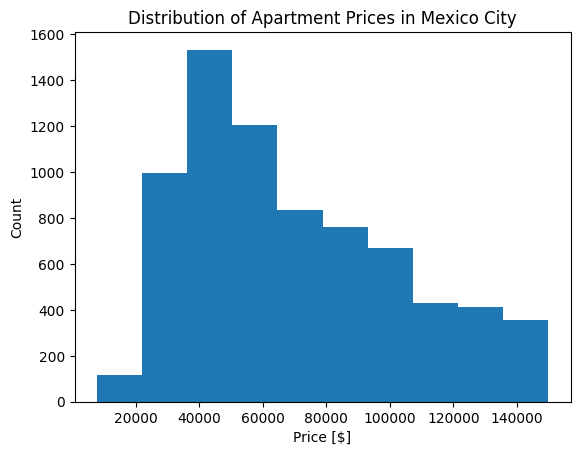

In [18]:
# Build histogram
plt.hist(x=df['price_usd'])

# Label axes
plt.xlabel('Price [$]')
plt.ylabel('Count')

# Add title
plt.title('Distribution of Apartment Prices in Mexico City');

The distribution of price is right-skewed.

I will create a scatter plot that shows apartment price as a function of apartment size.

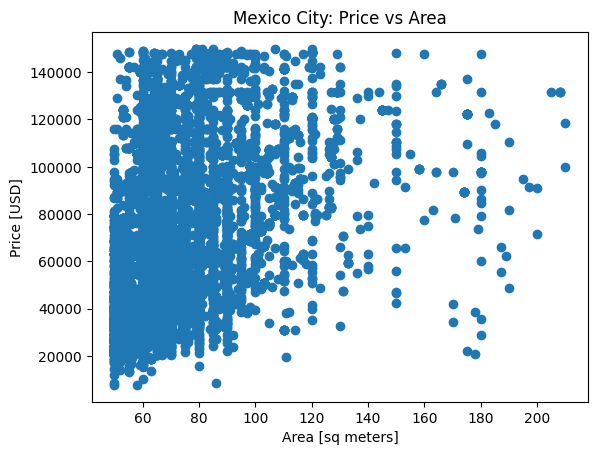

In [19]:
# Build scatter plot
plt.scatter(
    x=df['surface_area_m2'],
    y=df['price_usd']
)

# Label axes
plt.xlabel('Area [sq meters]')
plt.ylabel('Price [USD]')

# Add title
plt.title('Mexico City: Price vs Area');

There's no obvious relationship between price and area.

## Splitting Data

I will now create the feature and target arrays. The target is what I want to predict, and the features are what I'll use to make the prediction.

features `X`: `surface_area_m2`, `lat`, `lon`, `borough`

target `y`: `price_usd`

In [20]:
# Create feature and target arrays
X = df.drop("price_usd", axis=1).values
y = df["price_usd"].values

I will now split the data into training set and test set with `train_test_split`. 30% of the data will be used as test set

In [21]:
# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)


## Build Model

### Baseline


The first step in building a model is baselining, which involves making the same simple prediction for all apartments, regardless of size or location. In this case, the prediction will be the average price.

I will apply this prediction to each observation in the training set.

In [22]:
# Calculate mean of the target array, price
y_mean = y_train.mean()

# Generate the mean for each observation
y_pred_baseline = [y_mean] * len(y_train)

print(y_mean)
print(y_pred_baseline[:5])

69699.70015823403
[np.float64(69699.70015823403), np.float64(69699.70015823403), np.float64(69699.70015823403), np.float64(69699.70015823403), np.float64(69699.70015823403)]


I will use a performance metric to measure how well this baseline model performs. In this case I will use the mean absolute error.

Mean Absolute Error(mae) measures errors and show how far off the prediction they are.

In [23]:
# Fine the baseline mean absolute error
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean Apartment Price:", round(y_mean))
print("Baseline MAE:", round(mae_baseline))


Mean Apartment Price: 69700
Baseline MAE: 27912


This tells us that if we always predicted an apartment price of $69,700, our predictions would be off by an average of $27,912.

It also tells us that our model needs to have a mean absolute error below $27,912 in order to be useful.

### Iterate

The next step is iterating – building, training, and evaluating the model repeatedly until the performance improves. Since our target is numeric, we’ll use Linear Regression to predict by fitting a straight line to the data.

First, we need to handle missing values because Linear Regression can’t process them. We’ll use imputation to fill the gaps with values from the column using `SimpleImputer` from scikit-learn.

Our data also has non-numeric values (`borough`), but Linear Regression only works with numbers. We’ll convert these using `OneHotEncoder`. If needed, install it with:

```python
pip install category-encoders
```
To simplify the process, I’ll combine the transformations and the model into a pipeline called model, including:

- OneHotEncoder
- SimpleImputer
- LinearRegression

In [24]:
# Build model, along with the transformations, in a pipeline
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    LinearRegression()
)

# Fit the model to the training data
model.fit(X_train, y_train)


/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=[0, 1, 2, 3], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

### Evaluate

The final step is to evaluate the model. In order to do that, I'll use it to make predictions for data that it saw during training.

In [25]:
# Use the predict method on the training data
y_pred_training = model.predict(X_train)

Now that I have the predictions, I'll use it to assess the model's performance with the training data. I'll use the same metric I used to evaluate the baseline model: mean absolute error.

I'll calculate the training mae for the predictions in `y_pred_training` as compared to the true targets in y_train

In [26]:
# Calculate training mae
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training))

print("Baseline MAE:", round(mae_baseline))

Training MAE: 5649
Baseline MAE: 27912


The model beat the baseline model by over $20,000. That is a good indicator that it will be helpful in predicting apartment prices.

I will now see how the model performs on the test set using the model's `.predict()` method.

I will also find the mean absolute error for the prediction it makes

In [27]:
# Predict using the test set
y_pred_test = model.predict(X_test)

# Find the mae for the predictions
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", round(mae_test))

print(y_pred_test[0])


Test MAE: 14021
84696.11525061703


The test mean absolute error is lesser than the baseline mae by $13,000, which is a good indicator.

## Communicate Results

I will wrap the model in a function so that anyone can provide inputs and receive a predicted price as output.

The function will take 4 arguments: area, latitude, longitude and borough, and return the model's prediction for an apartent price.

In [53]:
def predict_apt_price(area, lat, lon, borough):
    data = [[
        area,
        lat,
        lon,
        borough
    ]]
    prediction = model.predict(data)[0]
    prediction = int(prediction)
    return f'Predicted apartment price: ${prediction:,}'


I will now test the function with the following parameters:
- area: 150
- lat: 19.39
- lon: -99.09
- borough: Iztacalco

In [55]:
# Test the function
predict_apt_price(100, 19.39, -99.09, "Iztacalco")

'Predicted apartment price: $43,342'